In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import gillespy2

In [4]:
import time
import numpy
import scipy.stats
from matplotlib import pyplot as plt
import pickle
import copy

In [5]:
sys.path.append('../test/')
import example_models

In [6]:
print(example_models.__all__)

['create_trichloroethylene', 'create_lac_operon', 'create_schlogl', 'create_michaelis_menten', 'create_decay', 'create_decay_no_tspan', 'create_tyson_2_state_oscillator', 'create_oregonator', 'create_vilar_oscillator', 'create_dimerization', 'create_degradation', 'create_robust_model', 'create_multi_firing_event', 'create_toggle_switch', 'create_telegraph_model']


In [7]:
all_model_names = ['create_decay',
 #'create_decay_no_tspan',
 #'create_degradation',
 'create_dimerization',
 #'create_lac_operon',
 'create_michaelis_menten',
 #'create_multi_firing_event',
 #'create_opioid',
 #'create_oregonator',
 #'create_robust_model',
 #'create_schlogl',
 #'create_telegraph_model',
 'create_toggle_switch',
 #'create_trichloroethylene',
 #'create_tyson_2_state_oscillator',
 #'create_vilar_oscillator'
]

In [8]:
# for m in all_model_names:
#     tic = time.time()
#     print(f"{m} started at {tic}")
#     model = eval(f"example_models.{m}")()
#     result = model.run()
#     print(f"{m} complete in {time.time() - tic}")
#     result.plot()

In [9]:
model = eval(f"example_models.{all_model_names[2]}")()
print(model.name)

Michaelis_Menten


In [10]:
%time result = model.run(solver=gillespy2.TauHybridSolver)

CPU times: user 807 ms, sys: 12.8 ms, total: 820 ms
Wall time: 794 ms


In [11]:
print(model.name)
for s in model.listOfSpecies:
    model.listOfSpecies[s].mode = 'discrete'

Michaelis_Menten


In [12]:
%time result = model.run(solver=gillespy2.TauHybridSolver)

running with a pure_discrete model
CPU times: user 277 ms, sys: 0 ns, total: 277 ms
Wall time: 275 ms


In [13]:
%time result = model.run(solver=gillespy2.TauLeapingSolver)

CPU times: user 77.5 ms, sys: 2.46 ms, total: 79.9 ms
Wall time: 78.8 ms


In [14]:
%time result = model.run(solver=gillespy2.TauLeapingCSolver)

CPU times: user 10 ms, sys: 11.5 ms, total: 21.6 ms
Wall time: 6.09 s


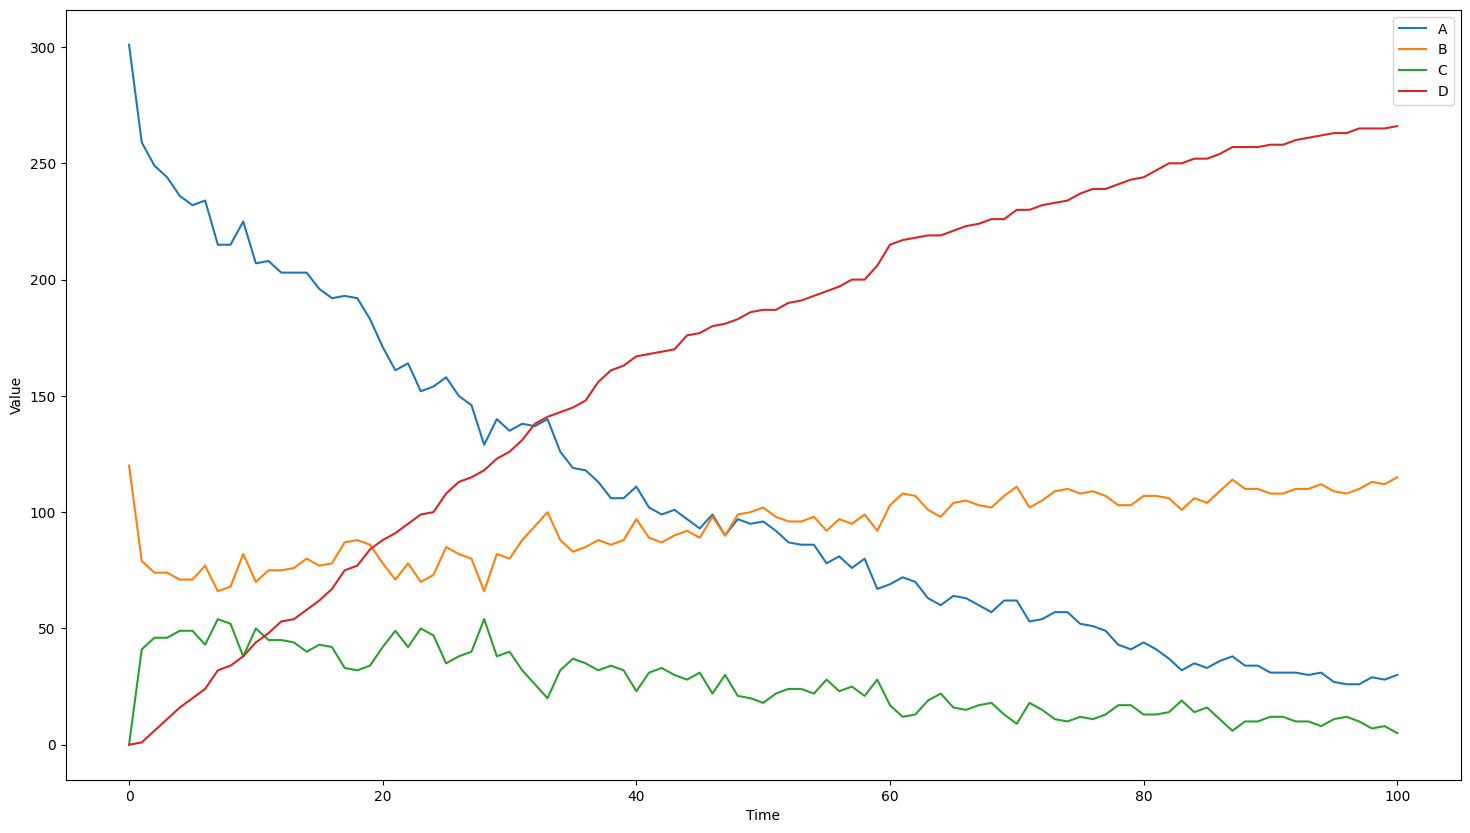

In [15]:
result.plot()

In [16]:
all_results={}
try:
    with open('all_results.p','rb') as fd:
        all_results = pickle.load(fd)
except FileNotFoundError: pass

In [17]:
all_solvers= [
gillespy2.SSACSolver,
gillespy2.NumPySSASolver,
gillespy2.TauLeapingCSolver,
gillespy2.TauLeapingSolver,
gillespy2.TauHybridCSolver,
gillespy2.TauHybridSolver,
]

In [18]:
print(model.name)
for solver in all_solvers:
    if solver.name in all_results:
        print(f"\tCached {solver.name}")
    else:
        print(f"\tRunning {solver.name}", end=' '*(20-len(solver.name)))
        tic = time.time()
        all_results[solver.name] = model.run(solver=solver, number_of_trajectories=1000)
        #all_results[solver.name].plot()
        print(f"\t\t{time.time()-tic}")

Michaelis_Menten
	Cached SSACSolver
	Cached NumPySSASolver
	Cached TauLeapingCSolver
	Cached TauLeapingSolver
	Cached TauHybridCSolver
	Cached TauHybridSolver


In [19]:
#with open('all_results.p','wb+') as fd:
#    pickle.dump(all_results,fd)

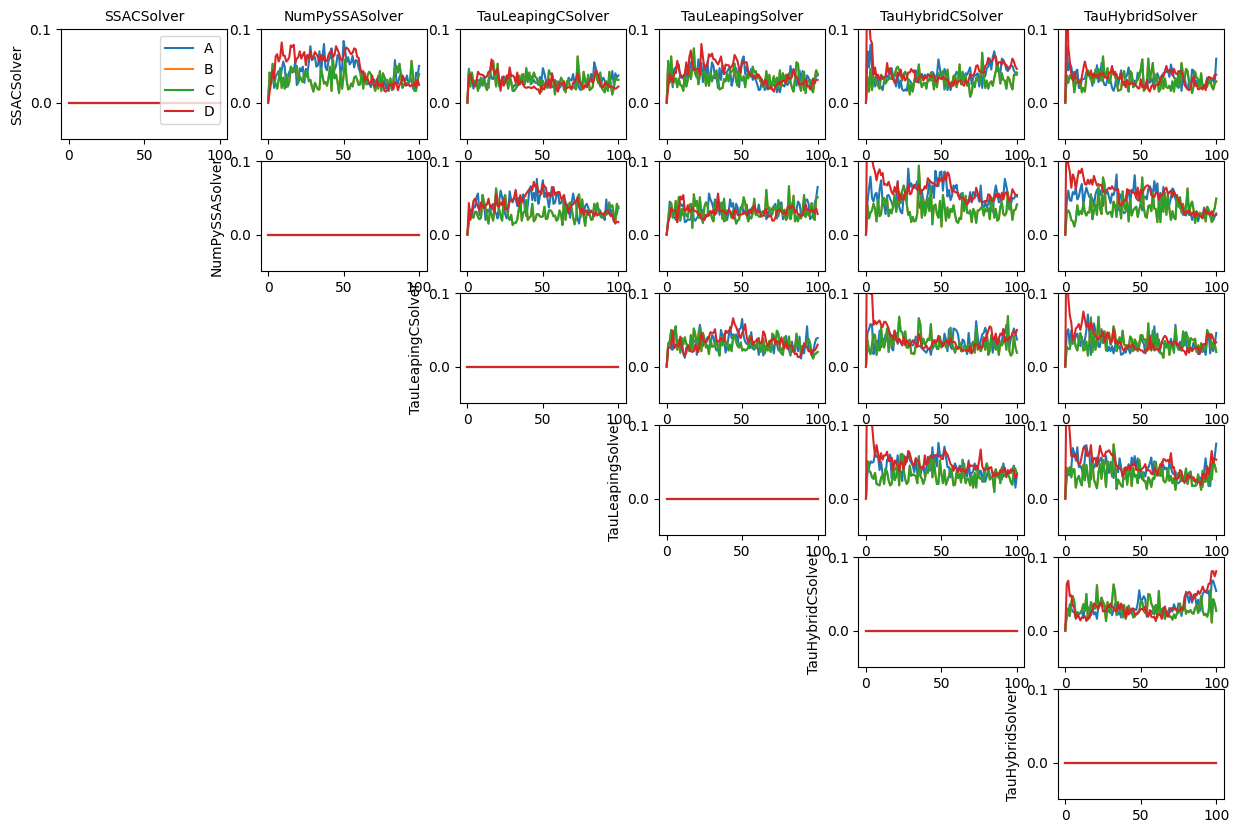

In [20]:
plt.figure(figsize=(15,10))
for ii in range(len(all_solvers)):
    s1 = all_solvers[ii].name
    for jj in range(ii,len(all_solvers)):
        #print(f"{ii},{jj}")
        plt.subplot(len(all_solvers),len(all_solvers),1+(ii*len(all_solvers)+jj))
        s2 = all_solvers[jj].name
        #print(f"{s1} <--ks_dist--> {s2}")
        for species in all_results[s1][0].keys():
            spec_dist = numpy.zeros((len(all_results[s1][0]['time'])))
            if species=='time':continue
            #print(species)
            for t_ndx,t in enumerate(all_results[s1][0]['time']):
                dist1 = numpy.zeros((len(all_results[s1])))
                for i,r in enumerate(all_results[s1]):
                    dist1[i] = r[species][t_ndx]
                dist2 = numpy.zeros((len(all_results[s2])))
                for i,r in enumerate(all_results[s2]):
                    dist2[i] = r[species][t_ndx]
                #print(f"t={t} \t{scipy.stats.ks_2samp(dist1,dist2).statistic}")
                spec_dist[t_ndx] = scipy.stats.ks_2samp(dist1,dist2).statistic
            plt.plot(all_results[s1][0]['time'],spec_dist,label=species)
            plt.ylim([-0.05, 0.1])
        if(ii+jj)==0: plt.legend(loc='best')
        if(ii==jj):plt.ylabel(s1, fontsize=10)
        if(ii==0): plt.title(s2, fontsize=10)
        
        

Based on the above plots, we can take the last 50% of the time points for each species and average everything into a single number.

# Show SSA Convergence as N->$\inf$

In [21]:
convergence_results = {}
try:
    with open('convergence_results.p','rb') as fd:
        convergence_results = pickle.load(fd)
except FileNotFoundError: pass
print(list(convergence_results.keys()))

[10.0, 1000.0, 100000.0, 100.0, 10000.0]


In [22]:
for Ntraj in [1e1, 1e2, 1e3, 1e4, 1e5]:
    if Ntraj not in convergence_results:
        convergence_results[Ntraj] = {}
    for solver in [gillespy2.NumPySSASolver,gillespy2.SSACSolver]:
        if solver.name not in convergence_results[Ntraj]: 
            convergence_results[Ntraj][solver.name] = {}
        for batch in ['A', 'B']:
            if batch in convergence_results[Ntraj][solver.name]: 
                print(f"cached  {Ntraj} {solver.name} {batch}")
            else:
                convergence_results[Ntraj][solver.name][batch] = {}
                ##
                print(f"running {Ntraj} {solver.name} {batch}", end='')
                tic = time.time()
                result = model.run(solver=solver, number_of_trajectories=int(Ntraj))
                print(f"\t\tdone in {time.time()-tic}")
                ##
                a = int(len(results[0]['time'])/2)
                b = len(results[0]['time'])
                dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
                #
                for s_ndx,species in enumerate(model.listOfSpecies):
                    for n_ndx in range(int(Ntraj)):
                        dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
                #
                convergence_results[Ntraj][solver.name][batch] = dist


cached  10.0 NumPySSASolver A
cached  10.0 NumPySSASolver B
cached  10.0 SSACSolver A
cached  10.0 SSACSolver B
cached  100.0 NumPySSASolver A
cached  100.0 NumPySSASolver B
cached  100.0 SSACSolver A
cached  100.0 SSACSolver B
cached  1000.0 NumPySSASolver A
cached  1000.0 NumPySSASolver B
cached  1000.0 SSACSolver A
cached  1000.0 SSACSolver B
cached  10000.0 NumPySSASolver A
cached  10000.0 NumPySSASolver B
cached  10000.0 SSACSolver A
cached  10000.0 SSACSolver B
cached  100000.0 NumPySSASolver A
cached  100000.0 NumPySSASolver B
cached  100000.0 SSACSolver A
cached  100000.0 SSACSolver B


In [23]:
print(list(convergence_results.keys()))

[10.0, 1000.0, 100000.0, 100.0, 10000.0]


In [24]:
#with open('convergence_results.p','wb+') as fd:
#    pickle.dump(convergence_results,fd)

In [25]:
convergence_results_analysis={}
x_vals = sorted(convergence_results.keys())
#print(x_vals)
#NumPySSASolver-self
y1_vals = numpy.zeros(len(x_vals))
y1_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['NumPySSASolver']['B'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y1_vals[y_ndx] = d_sum/d_cnt
    y1_errs[y_ndx] = d_ssum/d_cnt - (y1_vals[y_ndx]*y1_vals[y_ndx])
convergence_results_analysis['NumPySSASolver-self'] = (x_vals,y1_vals,y1_errs)
        
#SSACSolver-self
y2_vals = numpy.zeros(len(x_vals))
y2_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['SSACSolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['SSACSolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['SSACSolver']['B'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y2_vals[y_ndx] = d_sum/d_cnt
    y2_errs[y_ndx] = d_ssum/d_cnt - (y2_vals[y_ndx]*y2_vals[y_ndx])
convergence_results_analysis['SSACSolver-self'] = (x_vals,y2_vals,y2_errs)

#NumPySSASolver-SSACSolver
y3_vals = numpy.zeros(len(x_vals))
y3_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['SSACSolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['SSACSolver']['A'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y3_vals[y_ndx] = d_sum/d_cnt
    y3_errs[y_ndx] = d_ssum/d_cnt - (y3_vals[y_ndx]*y3_vals[y_ndx])
convergence_results_analysis['NumPySSASolver-SSACSolver'] = (x_vals,y3_vals,y3_errs)


###


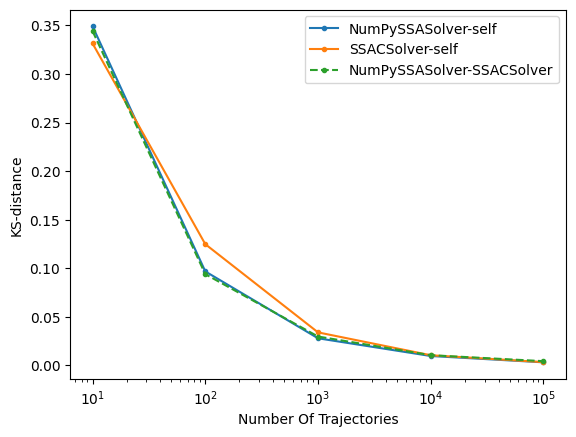

In [26]:
plt.semilogx(x_vals,y1_vals,'.-',label="NumPySSASolver-self")
plt.semilogx(x_vals,y2_vals,'.-',label="SSACSolver-self")
plt.semilogx(x_vals,y3_vals,'.--',label="NumPySSASolver-SSACSolver")
plt.ylabel("KS-distance")
plt.xlabel("Number Of Trajectories")
plt.legend(loc='best')

In [27]:
convergence_results_analysis['NumPySSASolver-self'][1][2]

0.02788235294117645

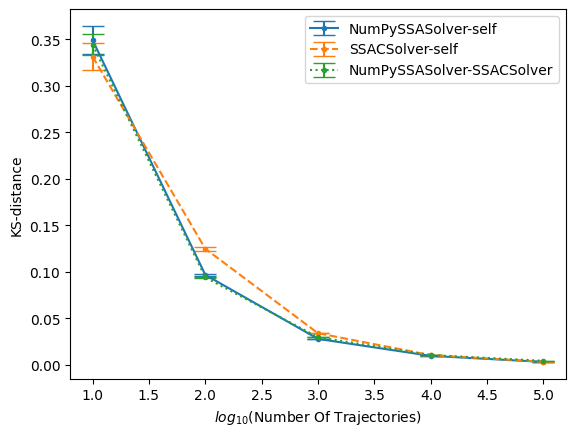

In [28]:
plt.errorbar(numpy.log10(x_vals),y1_vals,yerr=y1_errs,fmt='.-',capsize=8,label="NumPySSASolver-self")
plt.errorbar(numpy.log10(x_vals),y2_vals,yerr=y2_errs,fmt='.--',capsize=8,label="SSACSolver-self")
plt.errorbar(numpy.log10(x_vals),y3_vals,yerr=y3_errs,fmt='.:',capsize=8,label="NumPySSASolver-SSACSolver")
plt.ylabel("KS-distance")
plt.xlabel("$log_{10}$(Number Of Trajectories)")
_=plt.legend(loc='best')


From the above plot, we can see that 1e3 is a sufficient number of trajectories, and will run quickly

# Tau Stepsize Convergence

In [29]:
tau_convergence_results = {}
try:
    with open('tau_convergence_results.p','rb') as fd:
        tau_convergence_results = pickle.load(fd)
except FileNotFoundError: pass
print(sorted(list(tau_convergence_results.keys())))

[0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1]


In [30]:
#0==auto step size selection
tau_stepsize_values = [0, 1, 7.5e-1, 5e-1, 3.5e-1, 2e-1, 1e-1, 5e-2, 2.5e-2, 1e-2]  

Ntraj=1e3
tau_solvers = [gillespy2.TauHybridSolver, 
               gillespy2.TauHybridCSolver,
               gillespy2.TauLeapingSolver,
               gillespy2.TauLeapingCSolver,
              ]
for tau_stepsize in tau_stepsize_values:
    tau_stepsize_s=tau_stepsize
    if tau_stepsize==0: tau_stepsize_s='<auto>'
    if tau_stepsize not in tau_convergence_results:
        tau_convergence_results[tau_stepsize] = {}
    for solver in tau_solvers:
        if solver.name in tau_convergence_results[tau_stepsize]: 
            print(f"cached  {tau_stepsize_s} {solver.name}")
        else:
            ##
            print(f"running {tau_stepsize_s} {solver.name}", end='')
            tic = time.time()
            if tau_stepsize==0:
                sol_obj = solver(model=model)
            else:
                sol_obj = solver(model=model, constant_tau_stepsize=tau_stepsize)
            result = sol_obj.run(number_of_trajectories=int(Ntraj))
            print(f"\t\tdone in {time.time()-tic}")
            ##
            a = int(len(result[0]['time'])/2)
            b = len(result[0]['time'])
            dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
            #
            for s_ndx,species in enumerate(model.listOfSpecies):
                for n_ndx in range(int(Ntraj)):
                    dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
            #
            tau_convergence_results[tau_stepsize][solver.name] = dist


cached  <auto> TauHybridSolver
cached  <auto> TauHybridCSolver
cached  <auto> TauLeapingSolver
cached  <auto> TauLeapingCSolver
cached  1 TauHybridSolver
cached  1 TauHybridCSolver
cached  1 TauLeapingSolver
cached  1 TauLeapingCSolver
cached  0.75 TauHybridSolver
cached  0.75 TauHybridCSolver
cached  0.75 TauLeapingSolver
cached  0.75 TauLeapingCSolver
cached  0.5 TauHybridSolver
cached  0.5 TauHybridCSolver
cached  0.5 TauLeapingSolver
cached  0.5 TauLeapingCSolver
cached  0.35 TauHybridSolver
cached  0.35 TauHybridCSolver
cached  0.35 TauLeapingSolver
cached  0.35 TauLeapingCSolver
cached  0.2 TauHybridSolver
cached  0.2 TauHybridCSolver
cached  0.2 TauLeapingSolver
cached  0.2 TauLeapingCSolver
cached  0.1 TauHybridSolver
cached  0.1 TauHybridCSolver
cached  0.1 TauLeapingSolver
cached  0.1 TauLeapingCSolver
cached  0.05 TauHybridSolver
cached  0.05 TauHybridCSolver
cached  0.05 TauLeapingSolver
cached  0.05 TauLeapingCSolver
cached  0.025 TauHybridSolver
cached  0.025 TauHybridCSo

In [31]:
print(sorted(list(tau_convergence_results.keys())))

[0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1]


In [32]:
for t in list(tau_convergence_results.keys()):
    for s in list(tau_convergence_results[t].keys()):
        if s=='TauHybridCSolver':
            #del tau_convergence_results[t][s]
            print(t,s)

0 TauHybridCSolver
0.1 TauHybridCSolver
0.01 TauHybridCSolver
0.2 TauHybridCSolver
0.025 TauHybridCSolver
0.5 TauHybridCSolver
0.05 TauHybridCSolver
1 TauHybridCSolver
0.75 TauHybridCSolver
0.35 TauHybridCSolver


In [33]:
#with open('tau_convergence_results.p','wb+') as fd:
#    pickle.dump(tau_convergence_results,fd)

In [34]:
tau_convergence_results_analysis={}
x_vals = sorted(tau_convergence_results.keys())
#print(x_vals)
#TauHybridSolver(tau)-NumPySSASolver
y4_vals = numpy.zeros(len(x_vals))
y4_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauHybridSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y4_vals[y_ndx] = d_sum/d_cnt
    y4_errs[y_ndx] = d_ssum/d_cnt - (y4_vals[y_ndx]*y4_vals[y_ndx])
tau_convergence_results_analysis['TauHybridSolver(tau)-NumPySSASolver'] = (x_vals,y4_vals,y4_errs)
# ####
y5_vals = numpy.zeros(len(x_vals))
y5_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauHybridCSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y5_vals[y_ndx] = d_sum/d_cnt
    y5_errs[y_ndx] = d_ssum/d_cnt - (y5_vals[y_ndx]*y5_vals[y_ndx])
tau_convergence_results_analysis['TauHybridCSolver(tau)-NumPySSASolver'] = (x_vals,y5_vals,y5_errs)
####
y6_vals = numpy.zeros(len(x_vals))
y6_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauLeapingSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y6_vals[y_ndx] = d_sum/d_cnt
    y6_errs[y_ndx] = d_ssum/d_cnt - (y6_vals[y_ndx]*y6_vals[y_ndx])
tau_convergence_results_analysis['TauLeapingSolver(tau)-NumPySSASolver'] = (x_vals,y6_vals,y6_errs)
####
y7_vals = numpy.zeros(len(x_vals))
y7_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauLeapingCSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y7_vals[y_ndx] = d_sum/d_cnt
    y7_errs[y_ndx] = d_ssum/d_cnt - (y7_vals[y_ndx]*y7_vals[y_ndx])
tau_convergence_results_analysis['TauLeapingCSolver(tau)-NumPySSASolver'] = (x_vals,y7_vals,y7_errs)


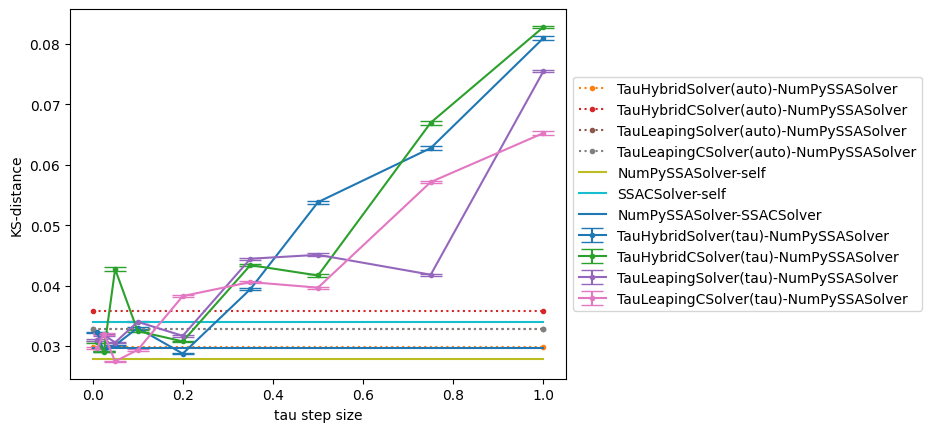

In [35]:
plt.errorbar(x_vals[1:],y4_vals[1:],yerr=y4_errs[1:],fmt='.-',capsize=8,label="TauHybridSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y4_vals[0],y4_vals[0]],'.:',label="TauHybridSolver(auto)-NumPySSASolver")

plt.errorbar(x_vals[1:],y5_vals[1:],yerr=y5_errs[1:],fmt='.-',capsize=8,label="TauHybridCSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y5_vals[0],y5_vals[0]],'.:',label="TauHybridCSolver(auto)-NumPySSASolver")

plt.errorbar(x_vals[1:],y6_vals[1:],yerr=y6_errs[1:],fmt='.-',capsize=8,label="TauLeapingSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y6_vals[0],y6_vals[0]],'.:',label="TauLeapingSolver(auto)-NumPySSASolver")

plt.errorbar(x_vals[1:],y7_vals[1:],yerr=y7_errs[1:],fmt='.-',capsize=8,label="TauLeapingCSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y7_vals[0],y7_vals[0]],'.:',label="TauLeapingCSolver(auto)-NumPySSASolver")


ssa1_self = convergence_results_analysis['NumPySSASolver-self'][1][2]
plt.plot([0,max(x_vals)],[ssa1_self, ssa1_self], label='NumPySSASolver-self')
ssa2_self = convergence_results_analysis['SSACSolver-self'][1][2]
plt.plot([0,max(x_vals)],[ssa2_self, ssa2_self], label='SSACSolver-self')
ssa3_self = convergence_results_analysis['NumPySSASolver-SSACSolver'][1][2]
plt.plot([0,max(x_vals)],[ssa3_self, ssa3_self], label='NumPySSASolver-SSACSolver')


plt.ylabel("KS-distance")
plt.xlabel("tau step size")
_=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [160]:
def run_model_tau_convergence(model, cache):
    #0==auto step size selection
    tau_stepsize_values = [0, 1, 7.5e-1, 5e-1, 3.5e-1, 2e-1, 1e-1, 5e-2, 2.5e-2, 1e-2]  

    Ntraj=1e3
    tau_solvers = [gillespy2.TauHybridSolver, 
                   gillespy2.TauHybridCSolver,
                   gillespy2.TauLeapingSolver,
                   gillespy2.TauLeapingCSolver,
                  ]
    ssa_solvers = [gillespy2.NumPySSASolver, gillespy2.SSACSolver]
    
    # run SSA solvers to show noise floor
    if 0 not in cache:
        cache[0] = {}
    for solver in ssa_solvers:
        if solver.name not in cache[0]:
            cache[0][solver.name] = {}
        for batch in ['A', 'B']:
            if batch in cache[0][solver.name]: 
                print(f"cached  Ntraj={int(Ntraj)} {solver.name} {batch}")
            else:
                ##
                print(f"running Ntraj={int(Ntraj)} {solver.name} {batch}", end='')
                tic = time.time()
                result = model.run(solver=solver, number_of_trajectories=int(Ntraj))
                print(f"\t\tdone in {time.time()-tic}")
                ##
                a = 0
                b = len(result[0]['time'])
                dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
                #
                for s_ndx,species in enumerate(model.listOfSpecies):
                    for n_ndx in range(int(Ntraj)):
                        dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
                #
                cache[0][solver.name][batch] = dist

    
    
    ignore_cache_list = [
        #'TauHybridCSolver',
        'TauHybridSolver',
    ]
    
    # run all the Tau solvers
    for tau_stepsize in tau_stepsize_values:
        tau_stepsize_s=tau_stepsize
        if tau_stepsize==0: tau_stepsize_s='<auto>'
        if tau_stepsize not in cache:
            cache[tau_stepsize] = {}
        for solver in tau_solvers:
            if solver.name in cache[tau_stepsize]:
                if solver.name in ignore_cache_list and tau_stepsize==0:
                    print(f"cached-rerunning  tau={tau_stepsize_s} {solver.name}")
                else:
                    print(f"cached  tau={tau_stepsize_s} {solver.name}")
                    continue
            ##
            print(f"running tau={tau_stepsize_s} {solver.name}", end='')
            mymodel = copy.deepcopy(model)
            print("\n\t converting all species to 'discrete'")
            for species in mymodel.listOfSpecies:
                mymodel.listOfSpecies[species].mode='discrete'

            tic = time.time()
            if tau_stepsize==0:
                sol_obj = solver(model=mymodel)
            else:
                sol_obj = solver(model=mymodel, constant_tau_stepsize=tau_stepsize)
            result = sol_obj.run(number_of_trajectories=int(Ntraj))
            print(f"\t\tdone in {time.time()-tic}")
            ##
            a = 0
            b = len(result[0]['time'])
            dist = numpy.zeros((b-a,len(mymodel.listOfSpecies),int(Ntraj)))
            #
            for s_ndx,species in enumerate(mymodel.listOfSpecies):
                for n_ndx in range(int(Ntraj)):
                    dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
            #
            cache[tau_stepsize][solver.name] = dist
                
    
    ############################################################
    def __analyze_full(data1,data2):
        out_arr = numpy.zeros((len(model.listOfSpecies),data1.shape[0]))
        for s_ndx,species in enumerate(model.listOfSpecies):
            for t_ndx in range(data1.shape[0]):
                out_arr[s_ndx,t_ndx] = scipy.stats.ks_2samp(
                            data1[t_ndx,s_ndx,:], 
                            data2[t_ndx,s_ndx,:]
                                    ).statistic
        return out_arr
    def __analyze_one(data1,data2):
        d_sum = 0
        d_ssum = 0
        d_cnt = 0
        for s_ndx,species in enumerate(model.listOfSpecies):
            for t_ndx in range(data1.shape[0]):
                d_cnt += 1
                val = scipy.stats.ks_2samp(
                            data1[t_ndx,s_ndx,:], 
                            data2[t_ndx,s_ndx,:]
                                    ).statistic
                d_sum += val
                d_ssum += val*val
        mu = d_sum/d_cnt
        sigma = d_ssum/d_cnt - (mu*mu)
        return (mu, sigma)
    
    def __analyze_all_tau(solver_name):
        x_vals = sorted(tau_stepsize_values)
        y_vals = numpy.zeros(len(x_vals))
        y_errs = numpy.zeros(len(x_vals))
        for y_ndx,tau_stepsize in enumerate(x_vals):
            (y_vals[y_ndx],y_errs[y_ndx]) = __analyze_one(
                        cache[0]['NumPySSASolver']['A'],
                        cache[tau_stepsize][solver_name]
                    )
        err_full = __analyze_full(
                    cache[0]['NumPySSASolver']['A'],
                    cache[0][solver_name]
                )
        return (x_vals, y_vals, y_errs, err_full)
    ############################################################
    # Analyze results
    tau_convergence_results_analysis={}

    print("Analyzing: NumPySSASolver-self")
    tau_convergence_results_analysis['NumPySSASolver-self'] = __analyze_one(
            cache[0]['NumPySSASolver']['A'],
            cache[0]['NumPySSASolver']['B']
        )
    
    print("Analyzing: SSACSolver-self")
    tau_convergence_results_analysis['SSACSolver-self'] = __analyze_one(
            cache[0]['SSACSolver']['A'],
            cache[0]['SSACSolver']['B']
        )
    
    print("Analyzing: NumPySSASolver-SSACSolver")
    tau_convergence_results_analysis['NumPySSASolver-SSACSolver'] = __analyze_one(
            cache[0]['NumPySSASolver']['A'],
            cache[0]['SSACSolver']['A']
        )
    
    
    print("Analyzing: TauHybridSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauHybridSolver-NumPySSASolver'] = __analyze_all_tau('TauHybridSolver')
    
    print("Analyzing: TauHybridCSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauHybridCSolver-NumPySSASolver'] = __analyze_all_tau('TauHybridCSolver')

    print("Analyzing: TauLeapingSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauLeapingSolver-NumPySSASolver'] = __analyze_all_tau('TauLeapingSolver')

    print("Analyzing: TauLeapingCSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauLeapingCSolver-NumPySSASolver'] = __analyze_all_tau('TauLeapingCSolver')

    return tau_convergence_results_analysis

In [161]:
def plot_model_tau_convergence(model, tau_convergence_results_analysis):
    plt.figure()
    for name in tau_convergence_results_analysis:
        if name[0:3] == 'Tau':
            (x_vals, y_vals, y_errs, err_full) = tau_convergence_results_analysis[name]
            plt.errorbar(x_vals[1:],y_vals[1:],yerr=y_errs[1:],fmt='.-',capsize=8,label=name.split('-')[0])
            plt.plot([0,max(x_vals)],[y_vals[0],y_vals[0]],'.:',label=f"{name.split('-')[0]} [AUTO]")
    for name in tau_convergence_results_analysis:
        if name[0:3] != 'Tau':
            ssa_self = tau_convergence_results_analysis[name][0]
            plt.plot([0,max(x_vals)],[ssa_self, ssa_self], label=name)
    plt.ylabel("KS-distance")
    plt.xlabel("tau step size")
    plt.title(model.name)
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [162]:
def plot_model_errorbars(model, cache):
    plt.figure()
    species= list(model.listOfSpecies.keys())
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for solver in cache[0]:
            if solver[0:3] == 'Tau':
                y_vals = numpy.mean(cache[0][solver][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                y_errs = numpy.var(cache[0][solver][:,s_ndx,:], axis=1)
                plt.errorbar(x_vals,y_vals,yerr=y_errs,fmt='.-',capsize=8,
                              label=solver)
            else:
                y_vals = numpy.mean(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                y_errs = numpy.var(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                plt.errorbar(x_vals,y_vals,yerr=y_errs,fmt='.-',capsize=8,
                              label=solver)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [163]:
def plot_model_means(model, cache):
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for solver in cache[0]:
            if solver[0:3] == 'Tau':
                y_vals = numpy.mean(cache[0][solver][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                plt.plot(x_vals,y_vals,label=solver)
            else:
                y_vals = numpy.mean(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                plt.plot(x_vals,y_vals,label=solver)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [164]:
def plot_model_trajectories(model, cache):
    sol_colors = ['cyan','blue','red','green','magenta','black']
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for sol_ndx, solver in enumerate(cache[0]):
            #if solver == 'NumPySSASolver': continue
            if solver == 'SSACSolver': continue
            #if solver == 'TauHybridSolver': continue
            if solver == 'TauHybridCSolver': continue
            if solver == 'TauLeapingSolver': continue
            if solver == 'TauLeapingCSolver': continue

            if solver[0:3] == 'Tau':
                #x_vals = numpy.arange(cache[0][solver].shape[0])
                x_vals = numpy.arange(10)
                for n_ndx in range(cache[0][solver].shape[2]):
                    y_vals = cache[0][solver][0:10,s_ndx,n_ndx]
                    if n_ndx==0:
                        plt.plot(x_vals,y_vals,color=sol_colors[sol_ndx],
                                 label=solver)
                    else:
                        plt.plot(x_vals,y_vals,alpha=0.01,color=sol_colors[sol_ndx])
            else:
                #x_vals = numpy.arange(cache[0][solver]['A'].shape[0])
                x_vals = numpy.arange(10)
                for n_ndx in range(cache[0][solver]['A'].shape[2]):
                    y_vals = cache[0][solver]['A'][0:10,s_ndx,n_ndx]
                    if n_ndx==0:
                        plt.plot(x_vals,y_vals,label=solver)
                    else:
                        plt.plot(x_vals,y_vals,alpha=0.01)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [165]:
def plot_model_trajectory_hist(model, cache):
    sol_colors = ['cyan','blue','red','green','magenta','black']
    species= list(model.listOfSpecies.keys())
    sol_blocks = [
        ['NumPySSASolver','TauHybridSolver','TauLeapingSolver'],
        ['SSACSolver','TauHybridCSolver','TauLeapingCSolver'],
    ]
    for sol_list in sol_blocks:
        plt.figure(figsize=(12,6*len(species)))
        n=1
        for t_ndx in range(10):
            for s_ndx, sname in enumerate(species):
                plt.subplot(10,len(species),n)
                n+=1
                plt.title(f"{sname} t={t_ndx}")
                h_colors = []
                h_data = []
                h_labels = []
                for sol_ndx, solver in enumerate(sol_list):

                    if solver[0:3] == 'Tau':
                        #plt.hist(cache[0][solver][t_ndx,s_ndx,:],
                        #        color=sol_colors[s_ndx], label=solver)
                        h_data.append(cache[0][solver][t_ndx,s_ndx,:])
                        h_colors.append(sol_colors[sol_ndx])
                        h_labels.append(solver)
                    else:
                        #plt.hist(cache[0][solver]['A'][t_ndx,s_ndx,:],
                        #        color=sol_colors[s_ndx], label=solver)
                        h_data.append(cache[0][solver]['A'][t_ndx,s_ndx,:])
                        h_colors.append(sol_colors[sol_ndx])
                        h_labels.append(solver)
                plt.hist(h_data, color=h_colors, label=h_labels)
                #plt.ylabel("Population")
                #plt.xlabel("time")
                if t_ndx==0 and s_ndx==0:
                    _=plt.legend(loc='center left')
        #_=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [166]:
def plot_model_image_maps(model, tau_convergence_results_analysis):
    sol_colors = ['cyan','blue','red','green','magenta','grey']
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname} (discrete)")

        for name in tau_convergence_results_analysis:
            if name[0:3] == 'Tau':
                (x_vals, y_vals, y_errs, err_full) = tau_convergence_results_analysis[name]
                #plt.plot(range(err_full.shape[1]),err_full[s_ndx,:],label=f"{name.split('-')[0]} [AUTO]")
                plt.plot(range(10),err_full[s_ndx,0:10],label=f"{name.split('-')[0]} [AUTO]")

#         for name in tau_convergence_results_analysis:
#             if name[0:3] != 'Tau':
#                 print(f"plot_model_image_maps: name={name}")
#                 ssa_self = tau_convergence_results_analysis[name][0]
#                 plt.plot(range(10),[ssa_self, ssa_self], label=name)

        plt.ylabel("KS-distance")
        plt.xlabel("time")
        _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# run all models tau convergence

In [144]:
all_models_tau_convergence_cache = {}
try:
    with open('all_models_tau_convergence_cache.p','rb') as fd:
        all_models_tau_convergence_cache = pickle.load(fd)
except FileNotFoundError: pass
print(sorted(list(all_models_tau_convergence_cache.keys())))

['create_decay', 'create_dimerization', 'create_michaelis_menten', 'create_opioid', 'create_schlogl', 'create_toggle_switch', 'create_tyson_2_state_oscillator', 'create_vilar_oscillator']


In [145]:
all_model_names

['create_decay',
 'create_dimerization',
 'create_michaelis_menten',
 'create_toggle_switch']

In [146]:
for model_name in sorted(list(all_models_tau_convergence_cache.keys())):
    if model_name not in all_model_names:
        print(model_name)

create_opioid
create_schlogl
create_tyson_2_state_oscillator
create_vilar_oscillator


Decay
Dimerization
cached  Ntraj=1000 NumPySSASolver A
cached  Ntraj=1000 NumPySSASolver B
cached  Ntraj=1000 SSACSolver A
cached  Ntraj=1000 SSACSolver B
cached-rerunning  tau=<auto> TauHybridSolver
running tau=<auto> TauHybridSolver
	 converting all species to 'discrete'
running with a pure_discrete model
		done in 29.63241744041443
cached  tau=<auto> TauHybridCSolver
cached  tau=<auto> TauLeapingSolver
cached  tau=<auto> TauLeapingCSolver
cached  tau=1 TauHybridSolver
cached  tau=1 TauHybridCSolver
cached  tau=1 TauLeapingSolver
cached  tau=1 TauLeapingCSolver
cached  tau=0.75 TauHybridSolver
cached  tau=0.75 TauHybridCSolver
cached  tau=0.75 TauLeapingSolver
cached  tau=0.75 TauLeapingCSolver
cached  tau=0.5 TauHybridSolver
cached  tau=0.5 TauHybridCSolver
cached  tau=0.5 TauLeapingSolver
cached  tau=0.5 TauLeapingCSolver
cached  tau=0.35 TauHybridSolver
cached  tau=0.35 TauHybridCSolver
cached  tau=0.35 TauLeapingSolver
cached  tau=0.35 TauLeapingCSolver
cached  tau=0.2 TauHybridS

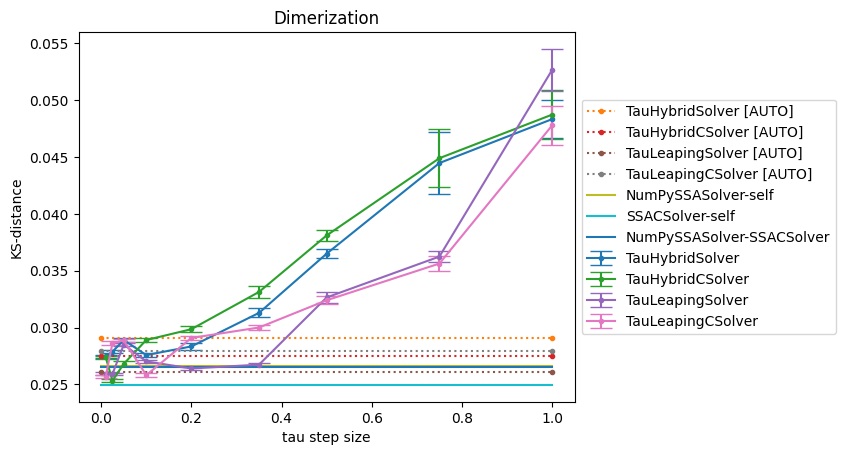

In [167]:
for m_ndx, mname in enumerate(all_model_names):
    mobj = eval(f"example_models.{mname}")()
    print(mobj.name)
    if mobj.name != 'Dimerization': continue
    tic = time.time()
    if mname not in all_models_tau_convergence_cache:
        all_models_tau_convergence_cache[mname] = {}
    analysis_results = run_model_tau_convergence(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_errorbars(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_trajectories(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_trajectory_hist(mobj, all_models_tau_convergence_cache[mname])
    plot_model_tau_convergence(mobj, analysis_results)
    #plot_model_image_maps(mobj, analysis_results)
    #plot_model_means(mobj, all_models_tau_convergence_cache[mname])
    print(f"\t\tdone in {time.time()-tic}")
    #if m_ndx>=3:break

In [168]:
with open('all_models_tau_convergence_cache.p','wb+') as fd:
    pickle.dump(all_models_tau_convergence_cache,fd)

In [48]:
all_model_names

['create_decay',
 'create_dimerization',
 'create_michaelis_menten',
 'create_toggle_switch']

In [49]:
ssa_data = all_models_tau_convergence_cache['create_dimerization'][0]['NumPySSASolver']['A']
ssa_data.shape

(101, 2, 1000)

In [50]:
tauH_data = all_models_tau_convergence_cache['create_dimerization'][0]['TauHybridSolver']
tauH_data.shape

(101, 2, 1000)

In [51]:
tauL_data = all_models_tau_convergence_cache['create_dimerization'][0]['TauLeapingSolver']
tauL_data.shape

(101, 2, 1000)

Dimerization


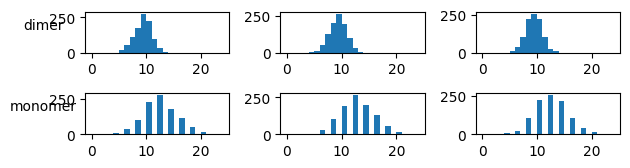

In [52]:
model = eval(f"example_models.{all_model_names[1]}")()
print(model.name)
n=1
for s_ndx, sname in enumerate(model.listOfSpecies):
    plt.subplot(6,3,n)
    n+=1
    plt.hist(ssa_data[-1,s_ndx,:], bins=range(25))
    plt.ylabel(sname, rotation='horizontal')
    plt.subplot(6,3,n)
    n+=1
    plt.hist(tauH_data[-1,s_ndx,:], bins=range(25))
    plt.subplot(6,3,n)
    n+=1
    plt.hist(tauL_data[-1,s_ndx,:], bins=range(25))
plt.tight_layout()

(array([  0.,   0.,   1.,   0.,   3.,   0.,  30.,   0., 102.,   0., 195.,
          0., 266.,   0., 202.,   0., 131.,   0.,  54.,   0.,  13.,   0.,
          3.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

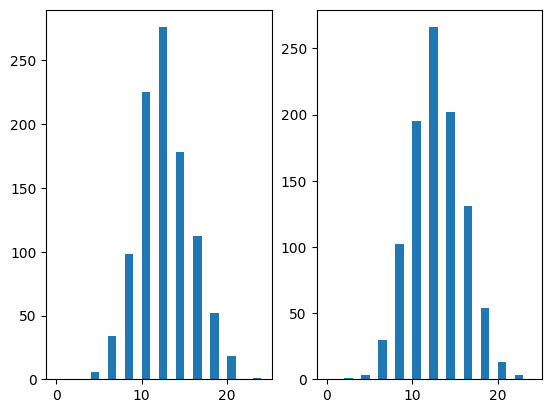

In [53]:
plt.subplot(1,2,1)
plt.hist(ssa_data[-1,1,:], bins=range(25))
plt.subplot(1,2,2)
plt.hist(tauH_data[-1,1,:], bins=range(25))

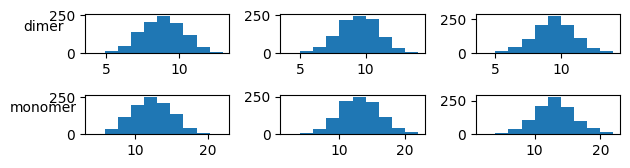

In [54]:
tauL_data = all_models_tau_convergence_cache['create_dimerization'][0]['TauLeapingCSolver']
tauH_data = all_models_tau_convergence_cache['create_dimerization'][0]['TauHybridCSolver']
ssa_data = all_models_tau_convergence_cache['create_dimerization'][0]['SSACSolver']['A']


n=1
for s_ndx, sname in enumerate(model.listOfSpecies):
    plt.subplot(6,3,n)
    n+=1
    plt.hist(ssa_data[-1,s_ndx,:])
    plt.ylabel(sname, rotation='horizontal')
    plt.subplot(6,3,n)
    n+=1
    plt.hist(tauH_data[-1,s_ndx,:])
    plt.subplot(6,3,n)
    n+=1
    plt.hist(tauL_data[-1,s_ndx,:])
plt.tight_layout()

(array([  0.,   0.,   1.,   0.,   6.,   0.,  32.,   0., 107.,   0., 223.,
          0., 247.,   0., 217.,   0., 112.,   0.,  39.,   0.,  15.,   0.,
          1.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

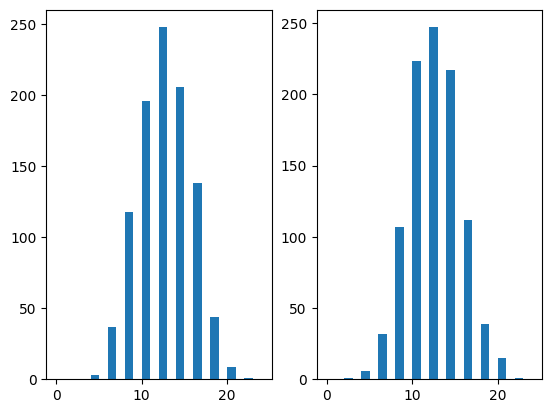

In [55]:
plt.subplot(1,2,1)
plt.hist(ssa_data[-1,1,:], bins=range(25))
plt.subplot(1,2,2)
plt.hist(tauH_data[-1,1,:], bins=range(25))

In [56]:
numpy.random.poisson(1)

0

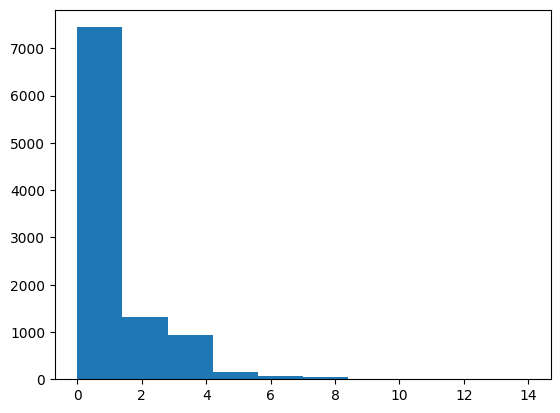

In [104]:
(cnts,_,_)=plt.hist(numpy.random.poisson(-1*numpy.log(numpy.random.uniform(0,1,size=10000))))


In [91]:
numpy.mean(-1*numpy.log(numpy.random.uniform(0,1,size=10000000)))

1.000018270763202

In [92]:
numpy.mean(numpy.random.poisson(-1*numpy.log(numpy.random.uniform(0,1,size=10000000))))

0.9993054

(array([63142., 23405.,  8544.,  3120.,  1115.,   431.,   161.,    54.,
           16.,     8.,     0.,     3.,     1.,     0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

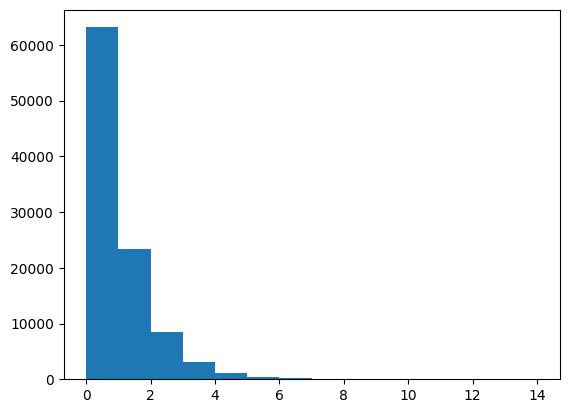

In [95]:
plt.hist(-1*numpy.log(numpy.random.uniform(0,1,size=100000)),bins=range(15))

In [97]:
23145+17114+9690+4384+2105+906+371+144+81+20+11

57971

In [98]:
57971/100000.0

0.57971

In [100]:
URN = numpy.random.uniform(0,1,size=100000)

In [102]:
numpy.sum(-1*numpy.log(URN))

100462.10491980064

In [103]:
numpy.sum(numpy.random.poisson(-1*numpy.log(URN)))

100707

[63158. 23034.  8741.  3238.  1143.   439.   154.    53.    20.    13.
     6.     1.     0.     0.]
100000.0
['0*63158.0=0.0', '1*23034.0=23034.0', '2*8741.0=17482.0', '3*3238.0=9714.0', '4*1143.0=4572.0', '5*439.0=2195.0', '6*154.0=924.0', '7*53.0=371.0', '8*20.0=160.0', '9*13.0=117.0', '10*6.0=60.0', '11*1.0=11.0', '12*0.0=0.0', '13*0.0=0.0']
0.5864


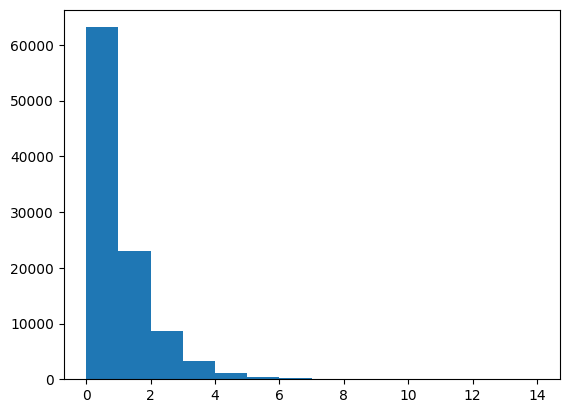

In [101]:
(cnts,_,_)=plt.hist(-1*numpy.log(URN),bins=range(15))
print(cnts)
print(sum(cnts))
print([f"{i}*{c}={i*c}" for i,c in enumerate(cnts)])
print(sum([i*c for i,c in enumerate(cnts)])/sum(cnts)  )